<center><font size="+2"><b><u> Relative peptide CA Z position </u></b></font></center>
<br></br>
<center> Negative values indicate insertion into the membrane </center>




In [3]:
import MDAnalysis
from MDAnalysis import analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from MDAnalysis.analysis import leaflet
from tqdm import tqdm

In [10]:
##gromacs configuration file###
gro_file_path = ''
##compressed trajectory file###
xtc_file_path = ''
u = MDAnalysis.Universe(gro_file_path, xtc_file_path, topology_format='GRO')

#### IMPORTANT  #######
# Specify number of peptides
pep_num = ''

if pep_num == '' or gro_file_path == '' or xtc_file_path == '':
    print("YOU FORGOT to specify your trajectory paths or number of peptides")

In [9]:
def get_peptide_range(res_start, pep_len, pep_num):
    """
    Creates a dictionary of the peptide and its respective residue ids e.g. {pep1:[1,2,3,4], pep2:[5,6,7]}

    Parameters
    ------------
    res_start: int
        The residue id of your first peptide residue
    pep_len: in
        Your peptide length
    pep_num: int
        Total number of peptides
    

    Return
    -----------
    pep_range: dict
        Dictionary of peptide numbers as keys and the lists of the respective residue ids as keys

    """
    pep_range = {}
    for i in range(pep_num):
        res_end = res_start+pep_len
        pep_range[f"pep{i+1}"] = list(range(res_start, res_end))
        res_start = res_end
    return pep_range

def get_aa_sequence(universe, pep_num):
    """
    Parameters
    ------------
    universe: MDAnalysis Universe object
    pep_num: int
        How many peptides the simulation contains
    
    Return
    ------------
    pep_num_dict: dict
        Dictionary of peptide numbers as keys and the lists of the respective residue ids as keys. 
    new_dict: dict
        Dictionary of residue_id: respective three-letter amino acid code e.g. {1: 'PHE', 2: 'LEU' ...}
    """
    protein_atoms = universe.select_atoms("protein")
    prot_residues = protein_atoms.residues
    res_names = prot_residues.resnames
    res_ids = prot_residues.residues.resids


    pep_len = int(len(res_ids)/pep_num)
    pep_num_dict = get_peptide_range(res_ids[0], pep_len, pep_num)
    seq_dict = dict(zip(res_ids, res_names))

    return pep_num_dict, seq_dict


In [56]:
def relative_zpos(u, pep_num, peptide_name):
    """
    Calculates the z position and saves it to a csv file.

    Parameters
    ------------
    u: MDAnalysis universe object
    pep_num: int
        The number of peptides in the system
    peptide_name: str
        Name of your peptide and the resulting csv file 
    
    Return
    -----------
    """
    # Get the dictionary of all residue id : amino acid type pairs
    pep_num_dict, seq_dict = get_aa_sequence(u, pep_num)

    # Print seq_dict to understand how it looks 
    print("seq_dict is: ", seq_dict)

    # Find membrane leaflets
    L = leaflet.LeafletFinder(u, 'name P')
    
    z_pos_list = []
    # Loop through the trajectory
    for ts in tqdm(u.trajectory[::50]):

        # Find the mean z position of the upper leaflet (mean z pos of P) and lower leaflet
        p_up = np.mean(L.groups(0).positions[:,[2]])
        p_low = np.mean(L.groups(1).positions[:,[2]])

        # Loop through all residues one at a time
        for res_id, res_name in seq_dict.items():

            timecount1 = u.trajectory.time

            # Calculate the z pos of each residue one at a time
            res_z_pos = np.mean(u.select_atoms(f"name CA and resid {res_id}").positions[:,[2]].astype(float))
            amino_num = res_name
  
            # Create list that contains which peptide the residue is in e.g. 1 if it's in peptide 1 etc
            pep = [k for k, v in pep_num_dict.items() if res_id in v][0]

            # Determine the actual insertion of each residue
            pep_insertion = res_z_pos - float(p_up)

            # Deal with peptides that cross the pbc on the other side of the membrane
            # This assumes that during the course of the sim the peptides don't actually go deeper than halfway through the membrane
            if pep_insertion < 0 and abs(pep_insertion) > (float(p_up) - float(p_low))/2:
                pep_insertion = float(p_low) - res_z_pos
            
            # Add all info about each residue insertion into a big list
            z_pos_list.append((timecount1, pep , res_id,  amino_num, pep_insertion/10, p_up))

    # Convert big list into a dataframe because it makes it easier to perform operations on the data and plot
    df = pd.DataFrame(z_pos_list, columns=["Time (ns)", "Peptide_num", "Resid", "Residue", "CA Z position", "P"])

    # Convert to various types
    df['Residue']= df['Residue'].astype('str')
    df['Time (ns)'] = df['Time (ns)'].astype(float)/1000
    df['Time (ns)'] = df['Time (ns)'].astype(int)
    df['Resid'] = df['Resid'].astype(int)

    # Calculate the length of each peptide
    pep_len = int(len(seq_dict)/pep_num)

    # Workout the equivalent residue numbers in each peptide e.g. using 4 peptides with  24 residues each 
    # and 96 residue total, workout the number of residue with resid 45 in peptide 2 - residue 45 would be 
    # residue number 21 in peptide 2. Useful for calculating average per residue number accross the peptides
    df['Residue_number'] = df['Resid'].apply(lambda x: x%pep_len if  x%pep_len != 0 else pep_len)
    # Save the data into a csv file
    df.to_csv(f"{peptide_name}.csv")


# Run function so the z-positions are calculated. Replace "my_pep" with the name you chose for your csv file - e.g. your peptide name 
# CSV files can be opened with excel
relative_zpos(u, 4, "my_pep" )


  0%|          | 0/1 [00:00<?, ?it/s]

seq_dict is:  {1: 'PHE', 2: 'LEU', 3: 'GLY', 4: 'ALA', 5: 'LEU', 6: 'ILE', 7: 'LYS', 8: 'GLY', 9: 'ALA', 10: 'ILE', 11: 'HIS', 12: 'GLY', 13: 'GLY', 14: 'ARG', 15: 'PHE', 16: 'ILE', 17: 'HIS', 18: 'GLY', 19: 'MET', 20: 'ILE', 21: 'GLN', 22: 'ASN', 23: 'HIS', 24: 'HIS', 25: 'PHE', 26: 'LEU', 27: 'GLY', 28: 'ALA', 29: 'LEU', 30: 'ILE', 31: 'LYS', 32: 'GLY', 33: 'ALA', 34: 'ILE', 35: 'HIS', 36: 'GLY', 37: 'GLY', 38: 'ARG', 39: 'PHE', 40: 'ILE', 41: 'HIS', 42: 'GLY', 43: 'MET', 44: 'ILE', 45: 'GLN', 46: 'ASN', 47: 'HIS', 48: 'HIS', 49: 'PHE', 50: 'LEU', 51: 'GLY', 52: 'ALA', 53: 'LEU', 54: 'ILE', 55: 'LYS', 56: 'GLY', 57: 'ALA', 58: 'ILE', 59: 'HIS', 60: 'GLY', 61: 'GLY', 62: 'ARG', 63: 'PHE', 64: 'ILE', 65: 'HIS', 66: 'GLY', 67: 'MET', 68: 'ILE', 69: 'GLN', 70: 'ASN', 71: 'HIS', 72: 'HIS', 73: 'PHE', 74: 'LEU', 75: 'GLY', 76: 'ALA', 77: 'LEU', 78: 'ILE', 79: 'LYS', 80: 'GLY', 81: 'ALA', 82: 'ILE', 83: 'HIS', 84: 'GLY', 85: 'GLY', 86: 'ARG', 87: 'PHE', 88: 'ILE', 89: 'HIS', 90: 'GLY', 91: 

100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Int64Index([100], dtype='int64', name='Time (ns)')


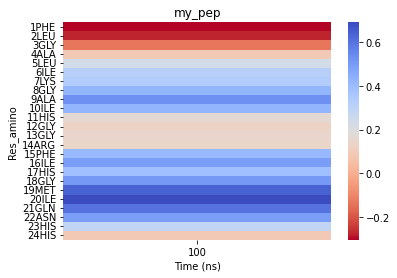

In [57]:
# Plotting
def plot_heatmaps(type_plot, peptide_name):

    # Read the CSV file with the z position data
    df = pd.read_csv(f"{peptide_name}.csv")

    """
    Parameters
    ------------
    peptide_name: str
        Name of peptie
    outuput_name: str
        Name of output/plot
    type_plot: str
        Choose one - average_by_peptide or average_by_residue or all 
    """
    if type_plot == "average_by_peptide":
        df = df.groupby(['Peptide_num', 'Time (ns)'])['CA Z position'].mean().unstack(-1)
    elif type_plot == "average_by_residue":
        df['Res_amino'] = df['Residue_number'].astype(str) + df['Residue']
        df = df.groupby(['Res_amino', 'Time (ns)'])['CA Z position'].mean().unstack(-1).sort_values(
            by='Res_amino', key=lambda col: col.str[:-3].astype(int)
        ,ascending=True)

        # df.sort_values('Residue_number', inplace=True)
        print(df.columns)




    else:
        df = df.groupby(['Resid','Time (ns)'])['CA Z position'].mean().unstack(-1)
        plt.figure(figsize=(10,18))

    sns.heatmap(df,cmap="coolwarm_r", yticklabels=df.index).set_title(f"{peptide_name}")
    plt.savefig(f'z_pos_{peptide_name}',bbox_inches="tight")

# instead of "all" you can use average_by_peptide or average_by_residue to plot different averages
# instead of my pep use the name of your peptide - that would aappear on your plot 
plot_heatmaps("average_by_residue", "my_pep")


##### Because the z-pos data is written into a csv file and stored locally and plotting is now separated 
# from calculations, once you ran the cell with the relative_zpos() function once, and are happy with
# the calculations, you won't need to run it again to generate different plots. If you want to generate 
# different plots e.g. average by residue, all peptides and all, you would just need to tun this cell
# containing the plot_heatmaps() function